## Collaborative Filtering with Alternating Least Squares on the Million Song Dataset

### Introduction

In 2016, more than half of all Americans consumed music through online streaming services on a weekly basis. Online streaming services generated $17.3 billion in revenue in 2017, up 8.1% from 2016. As more listening moves from mp3, AM/FM and physical mediums to streaming, online radio firms are relying on machine learning to rapidly personalize music selection and discovery for users in order to gain a competitive advantage in growing marketplace. Companies such as Spotify and Google have purchased smaller technology start-ups for their audio machine learning solutions (EchoNest) or their extensive customer data (Songza) to get leg up in this digital arms race.

Streaming companies utilize a variety of methods to recommend music to their users. Pandora allows users to give songs  a “thumbs up or down” to indicate positive or negative preference. This explicit feedback helps Pandora quickly create personalized playlists, where songs with similar attributes are served to the user based off their rating feedback. Spotify generates playlists based off your listeneing history and factors in everything from time of day to location. With machine learning, a streaming company can use a variety of data to infer a listener’s taste and recommend songs the user is more likely to prefer automatically. Using recommendation systems, companies can create personalized playlists and radio stations without employing taste-makers or experts. 

### Recommendation Systems

Recommendation systems can be broken into two categories: content-based and collaborative filters. Content-based systems rely on attributes related to the item/product (a song or artist in this case) to make recommendations to a user based off known user data. While this approach is effective, it requires storing a large amount of data about the users and items. Often times, companies don't always have customer data to create this type of recommendation system.
    
A collaborative filter creates a recommendation engine using a user identifier, an item identifier and some rating metric that shows an interaction between the user and item. Based off a collection these user/item interactions, the collaborative filter can predict a user's potential item preference based off users with similar tastes. Similarly, a collaborative filter can infer item similarities. 
        
Collaborative filters can deal with two types ratings data: explicit or implicit. Explicit data means a user has directly made their preference known--similar to Pandora's thumbs up or thumbs down or a 5-star rating system like Yelp's restaurant reviews. Implicit ratings are a feedback metric that does not necessarily give us a user's preference, but we can potentially infer preference--like a product purchase, time spent on a webpage or a song play. A using song plays as an example, a single listen to a song does not necessarily mean the user likes that song, but the more times a user listens to that same song, we can more confidently infer the user has a positive preference for said song. While implicit metrics sacrifice a degree of certainty, implict data is much easier to come by in the real world. 
    
    
### The Task

The Million Song Challenge (MSC) data set is ideal for creating a recommendation system. Moreover, its format allows us to create a collaborative filter using implicit data. The dataset itself contains over 1 million unique user’s listening data and over 300,000 songs. The task is to create a robust recommendation system with just the interaction between users and songs. As a basis of comparison, we will be comparing the performance of our recommender model to serving the most popular song any given user has not listened to. This is a high bar to clear, as recommending the most popular item tends have a higher accuracy than a recommendation system
       
Given the structure of the dataset, which is sparse--as most users will have only listened to several songs, and we are dealing with implicit ratings data, I will use an Alternating Least Squares (ALS) algorithm with matrix factorization. 
    
### Matrix Factorization

Matrix factorization is a form of latent factor analysis. We start with a sparse matrix M which consists of users by items with ratings metric (song plays) in the cells. With matrix factorization, we factor matrix M into two separate matrices, X and Y; these matrices contain latent factors which reduce large numbers of interactions between users and items into several hidden or unobserved reasons. The X matrix is the users by these hidden features while the Y matrix is the items * hidden factors. Both matrices have a observations which  correspond with either a user or feature from the original matrix M. We then take the product of these matrices to fill in the missing entries of M to provide the liklihood of a user prefering an item.
    
$$M = XY^T$$
    
The ALS algorithm is used to find, or approximate, X and Y. Both X and Y aren't known, so values are randomly initialized, first for Y. Then X is solved given the random values of Y and M. Using linear algebra, the algorithm solves for each row of X (i).
    
$$M_1Y(Y^TY)^{-1} = X_i$$

Since the algorithm will not arrive at the exact equivalent, since X and Y are too small/low rank to equal M, values are optimized by minimizing the sum of squared differences between the both matrix entries. 
    
In an implicit scenario, our original matrix M is converted to a binary preference matrix, matrix B. Matrix M is kept to incorporate the positive values as weights. For example, a user who listened to a song 100 times will be said to have more preference than someone who listened to a song 2 times.The equation for deriving the confidence matrix is below:

$$C_{ui} = 1 + \alpha r _{ui}$$


$$C_{ui}$$ is the confidence matrix for users and items. $$\alpha$$ is a scaling value which controls the weight of observed vs. unobserved interactions in the factorization process. $$ r_{ui} is the original matrix, M.

ALS minimizes the cost function with the following equation below

$$x_u = (Y^TC^uY + \lambda I)^{-1}Y^TC^up(u)$$

Probability of U is the vector of all preferences by u (user) in in binary form. Lambda is the regularization term to avoid overfitting in the training phase. 

In [1]:
# Import the relevent libraries

import numpy as np
import pandas as pd
import scipy.sparse as sp
import sys
import random
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
import implicit
from tqdm import tqdm_notebook as tqdm




In [2]:
# Import the training and test data

# Training data
train = pd.read_csv('train_triplets.txt', delimiter = '\t', header = None)
train.columns = ['users', 'songs', 'play_count']

# Test data
test = pd.read_csv('kaggle_visible_evaluation_triplets.txt', delimiter = '\t', header = None, names = ['users', 'songs', 'play_count'])


### Train-Test Split?

Typical machine learning problems involve training an algorithm on a one dataset and then testing the model on a hold-out dataset. This approach will not work here, as we need all possible user-item interactions to optimize our latent factors vectors. We want to reduce the amount of sparsity as much as possible. Instead we will mask a certain percentage of user-item interactions and see if our algorithm correctly predicted if a user preferred that song.



In [3]:
# combining the two dataframe

df = pd.concat([train, test], ignore_index = True)


### Track information 

There is a separate .txt file which maps the song ID from the main dataset to the actual song name and artist name. This information will be useful later when analyzing the results of the data. Viewing the recommendations as songIDs will not be as intuitive as viewing them as a collection of recongnizable songs. 

In [4]:
# import track and artist information for later analysis

track_info = pd.read_csv('unique_tracks.txt', header = None, delimiter = '\<SEP>', names = ['track_id', 'songs', 'artist', 'song_title'] )

# drop duplicates by songID

track_info = track_info.drop_duplicates(subset = ['songs'])

track_info['song_artist'] = track_info['song_title'] + (" - ") + track_info['artist']

# merge dataframe

df_track = df.merge(track_info[['songs', 'song_artist']], on = 'songs', how = 'inner')

# check first and last 5 entries of new dataframe

df_track.head()

/Users/cpacewicz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,users,songs,play_count,song_artist
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove - Jack Johnson
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,The Cove - Jack Johnson
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,The Cove - Jack Johnson
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,The Cove - Jack Johnson
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,The Cove - Jack Johnson


In [5]:
df_track.tail()

,users,songs,play_count,song_artist
49824514,a04a1a9855dcbeab1ed2893610340a1da7afc912,SOHNHAR12AB0182868,1,I'll Sing A Sweeter Song Tomorrow - The Deathr...
49824515,90f11a614cff00b1b9b6faa4dbba21bea91537ad,SOBXYMP12A6D4F6138,1,Take A Chance - Bill Laswell
49824516,8232bf455c6e53e999c31ee6d042cb07ee6f9c40,SOIYSQG12AB01825DB,2,La Egoista - Diomedes Diaz _ Juancho Rois
49824517,8232bf455c6e53e999c31ee6d042cb07ee6f9c40,SOBIARX12AB0189A77,1,El Parquecito - Diomedes Diaz;Juancho Rois
49824518,53809ef0b5ce3219d46ee6c1a9e37e44b6cebeb0,SOCMDDE12A8C13DDAD,1,TV News - Roger Miret & The Disasters


### Exploratory Data Analysis

Unlike more traditional machine learning tasks, the exploratory data analysis phase is limited, since there are relatively few fields. There is still value in performing basic exploration. 

In [6]:
print(df_track['play_count'].describe().apply(lambda x: format(x, 'f')))

# How many unique users

print("Number of unique users: " + str(len(df_track['users'].drop_duplicates())))

# How many unique songs

print("Number of unique songs: " + str(len(df_track['songs'].drop_duplicates())))

# Check for null values

print("Number of null ratings: " + str(df_track['play_count'].isnull().sum()))


count    49824519.000000
mean            2.876186
std             6.456653
min             1.000000
25%             1.000000
50%             1.000000
75%             3.000000
max          9667.000000
Name: play_count, dtype: object
Number of unique users: 1129318
Number of unique songs: 385371
Number of null ratings: 0


In [7]:
# Check top played songs

song_pivot = df_track.pivot_table(index = 'song_artist',
                                  values = "play_count",
                                  aggfunc = sum)

print(song_pivot.sort_values('play_count', ascending= False))

                                                    play_count
song_artist                                                   
You're The One - Dwight Yoakam                          762317
Undo - Björk                                            681418
Revelry - Kings Of Leon                                 552252
Sehr kosmisch - Harmonia                                444917
Horn Concerto No. 4 in E flat K495: II. Romance...      406995
Dog Days Are Over (Radio Edit) - Florence + The...      370812
Secrets - OneRepublic                                   305034
Canada - Five Iron Frenzy                               284548
Invalid - Tub Ring                                      279147
Ain't Misbehavin - Sam Cooke                            256340
Représente - Alliance Ethnik                            251354
Catch You Baby (Steve Pitron & Max Sanna Radio ...      247009
Sincerité Et Jalousie - Alliance Ethnik                 234624
Hey_ Soul Sister - Train                               

In [8]:
# Check distribution

print(df_track['play_count'].quantile(np.arange(0,1,0.1)))


0.0    1.0
0.1    1.0
0.2    1.0
0.3    1.0
0.4    1.0
0.5    1.0
0.6    2.0
0.7    2.0
0.8    3.0
0.9    6.0
Name: play_count, dtype: float64


/Users/cpacewicz/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


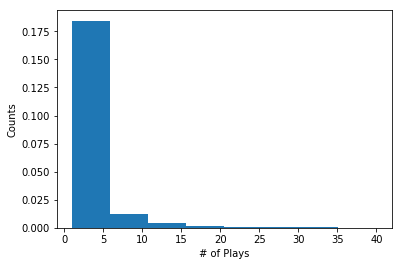

In [9]:
# Plot histogram for distribution
_ = plt.hist(df_track['play_count'],  bins = 8, range = [1, 40], normed = True )
_ = plt.ylabel('Counts')
_ = plt.xlabel('# of Plays')
plt.show()



### Data Preprocessing

The ALS algorithm requires that our data be in the form of a sparse matrix of users * items with interactions (play count) in the cells. Therefore, we will create a sparse matrix with the relevent columns. We must also encode the user and item variables for faster processing. We will map these codes to the song title and artist name for interpreting our model at a later point. 

While performing preprocessing, we will also check the sparsity of the matrix.

In [10]:
# Encode relevent variables

df_track['user_id'] = df_track['users'].astype("category").cat.codes
df_track['song_id'] = df_track['songs'].astype("category").cat.codes

In [11]:
# Create sparse matrix of user * item interactions

sp_item_user = sp.csr_matrix((df_track['play_count'].astype(float), (df_track['song_id'], df_track['user_id'])))

# Calculate density

sparsity = 1-(df_track.shape[0] / (df_track.user_id.unique().shape[0] * df_track.song_id.unique().shape[0]))
print("Total Sparsity: " + str(sparsity))

Total Sparsity: 0.9998855151987629


### Testing Recommendation Efficacy

As previously mentioned, using a traditional test-train split will not work for our purposes. We will use a function that masks a certain percentage of user-item interactions on a validation set of data. After creating our recommender, we will check to see if our model ended up serving songs the user already listened to in the masked entry.

In [12]:
def train_test_mask(sp_matrix, test_split = 0.1):
  
    val_set = sp_matrix.copy() # make test set from train data 
    val_set[val_set != 0] = 1 # Create unary matrix, all interactions
    train = sp_matrix.copy() # train set where certain interactions will be hidden
    nonzero_inds = train.nonzero() # use nonzero method to store user/items with interactions
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # list of user/song interactions that aren't zero
    random.seed(123) # set random seed for reproducability
    mask_number = int(np.rint(test_split*len(nonzero_pairs))) #  # of samples
    masked = random.sample(nonzero_pairs, mask_number) # Sample a random number of user-item pairs (no replacement)
    item_inds = [index[0] for index in masked] # All song column indices
    user_inds = [index[1] for index in masked] # All user row indices
    train[item_inds, user_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero thereby masking them
    train.eliminate_zeros() # Delete zeros in sparse array storage after update to save space
    return train, val_set, list(set(item_inds)) # returns unique group of masked items


In [13]:
train, val_set, masked_list = train_test_mask(sp_item_user)

### Creating the model

A python package called Implicit is a great out-of-the-box option for creating a collaborative filter using the ALS method. This package uses Cython for processing code with different threads and the syntax is very straightforward. The hyperparameters are alpha, which is a scaling value for our ratings matrix, regularization, an overfitting parameter, number of factors, the number of hidden or latent factors and iterations, which is the number of times to switch between the user and item matrices in the alternating least squares process. We used the basic parameters here (hyperparameter tuning is restricted here due to memory constraints--see next section in Spark)

In [14]:
# Use alternating Least Squares to create recommendation algorithm

alpha = 15
rec = implicit.als.AlternatingLeastSquares(factors = 20, regularization = 0.1,
                                           iterations = 20) 
rec.fit(train * alpha)

# Create latent features object for users and items respectively 
item_vec, user_vec_t = rec.item_factors, rec.user_factors.transpose() # transpose for matrix operations

# create user item sparse matrix for looking up recommendations results
sp_user_item = sp_item_user.T.tocsr()


        

100%|██████████| 20.0/20 [10:03<00:00, 30.89s/it]


In [15]:
## Spot check recommendations for a user

# Choose user (arbitrary)
user = 10

# Function to return a dataframe of song recommendations
def user_recommendations(user, sp_matrix):
    songs = []   # create list for recommended songs
    scores = []  #  store recommendation scors
    recommended_songs = rec.recommend(user, sp_matrix)  # use implicit recommend function
    for song in recommended_songs:
        idx, score = song    # store index and score of song
        songs.append(df_track.song_artist.loc[df_track.song_id == idx].iloc[0])   # use song index to append song title and artist name
        scores.append(score)   # append score to list
        
        recommendations = pd.DataFrame({'songs': songs, 'score': scores})      # create dataframe of results
    return recommendations


user_recommendations(user, sp_user_item)

,songs,score
0,Elephant Gun - Beirut,0.161170
1,There Is A Light That Never Goes Out - The Smiths,0.158865
2,Quelqu'un M'a Dit (Album Version) - Carla Bruni,0.154508
3,Wild World - Cat Stevens,0.151159
4,Boys Don't Cry - The Cure,0.150795
5,Heartbeats - José Gonzalez,0.143932
6,Nantes - Beirut,0.139389
7,Am I A Fool - Sense Field,0.138196
8,Between The Bars - Elliott Smith,0.137535
9,Sehr kosmisch - Harmonia,0.135473


### Testing Recommendation Efficacy continued



In [16]:
# Area under the curve (AUC) score function

def auc_score(pred, actual):

    fpr, tpr, thresholds = metrics.roc_curve(actual, pred)
    return metrics.auc(fpr, tpr)  



# Creating ROC curve and evaluating our model against a naive model which serves the most popular song the user has not previously listened to
# by comparing the AUC scores

def area_under_curve(training_set, masked_list, predictions, val_set):

    
    als_auc = [] # list for item that
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(val_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    vec1 = predictions[1]
    with tqdm(total=len(masked_list), file=sys.stdout) as pbar:
        for index, user in enumerate(masked_list): # Iterate through each user that had an item altered
            training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
            zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
            # Get the predicted values based on our user/item vectors
            vec2 = predictions[0][user,:]
            pred = vec2.dot(vec1).toarray()[0,zero_inds].reshape(-1)
            # Get only the items that were originally zero
            # Select all ratings from the MF prediction for this user that originally had no iteraction
            actual = val_set[user,:].toarray()[0,zero_inds].reshape(-1) 
            # take the unary 1/0 interaction pairs from the original matrix
            # which align with the same pairs in train set 
            pop = pop_items[zero_inds] # Get most popular item
            als_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user
            popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular
            #pbar.set_description('processed: %d als_auc: %d percent pop_auc: %d percent' % (1 + index, 100 * np.mean(als_auc), (100 * np.mean(popularity_auc))))
            pbar.update(1)
        
    
    return float('%.3f'%np.mean(als_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC for our model and the most popular item for comparison


In [25]:

area_under_curve(train, masked_list[:30000], 
              [sp.csr_matrix(item_vec), sp.csr_matrix(user_vec_t)], val_set)



(0.827, 0.771)

### Tuning our Model

Our model outperformed serving the most popular song on a subset of 1000 altered entries, but neither recommendation system was particularly high.

An issue with the initial model is the overall sparsity of of our item * user matrix. In order to tune our model further, we will reduce the sparsity of our model by removing users and items below a certain threshold of interactions.  Our dataset as is has a sparisty level of 99.98%. Therefore we will remove all users who have listened below x number of songs and songs not listened to until our model reaches our model is less than 99.95% sparse. This will remove a large amount of data, but will make our recommender more robust. 

In [18]:
# encode relevent variables on original dataset
df['user_id'] = df['users'].astype("category").cat.codes
df['song_id'] = df['songs'].astype("category").cat.codes

df = df[['user_id', 'song_id', 'play_count']]


In [19]:
# Create function to remove users and songs below certain number of interactions
def activity_thresh(df, user_min, song_min):
    while True:
        start_dim = df.shape[0]
        song_counts = df.groupby('user_id').song_id.count()
        df = df[~df.user_id.isin(song_counts[song_counts < song_min].index.tolist())]
        user_counts = df.groupby('song_id').user_id.count()
        df = df[~df.song_id.isin(user_counts[user_counts < user_min].index.tolist())]
        end_dim = df.shape[0]
        if start_dim == end_dim:
            break
    n_users = df.user_id.unique().shape[0]
    n_items = df.song_id.unique().shape[0]
    sparsity = 1- (float(df.shape[0]) / float(n_users*n_items))
    print('Number of users: {}'.format(n_users))
    print('Number of songs: {}'.format(n_items))
    print('Sparsity: {:.5%}'.format(sparsity))
    return df, sparsity


# Create a loop that stops at a certain sparsity threshold
#for i in range(25,50,2):
#    print('Min user and song count: {}'.format(i))
#    _, sparsity = activity_thresh(df, i, i)
#    if sparsity < 0.9995:
#        break
#    else:
#        continue
        


In [20]:
# Create a reduced dataframe 
df_red, _ = activity_thresh(df, 25, 25)



Number of users: 548135
Number of songs: 131637
Sparsity: 99.94577%


In [21]:
# Create item/user and user/item sparse matrices
sp_item_user = sp.csr_matrix((df_red['play_count'].astype(float), (df_red['user_id'], df_red['song_id'])))


# Creating the second version of our model
train_2, val_set_2, masked_list_2 = train_test_mask(sp_item_user)

In [22]:
# Use alternating Least Squares to create recommendation algorithm--add 50 factors now as well

alpha = 15
rec2 = implicit.als.AlternatingLeastSquares(factors = 50, regularization = 0.1,
                                           iterations = 20)
rec2.fit(train_2 * alpha)


item_vec_2, user_vec_t_2 = rec2.item_factors, rec2.user_factors.transpose()


100%|██████████| 20.0/20 [10:24<00:00, 30.54s/it]


In [26]:
# Create another model with the 
area_under_curve(train_2, masked_list_2[:30000], 
              [sp.csr_matrix(item_vec_2), sp.csr_matrix(user_vec_t_2)], val_set_2)



(0.95, 0.952)

### Final Thoughts -- Next Steps

The AUC score improved after removing user/item interactions below a threshold of 25. To improve our model further, the hyperparameters of the ALS algorithm will need to be tuned. However, this requires more computing power than a standard desktop allows for--running the AUC curve function took ~2 days on my machine. The most expedient way to improve this model would be to use a distributed framework like Spark. 

References:

- Recommender Systems; Charu C. Aggarwal; 2016
- Advanced Analytics with Spark; Sean Owen; 2017
- http://yifanhu.net/PUB/cf.pdf
- https://jessesw.com/Rec-System/
- https://github.com/benfred/implicit

    
    